In [2]:
# Gautam Jain, Jannis Horn 

#%matplotlib notebook
import time
from typing import Tuple
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch  
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as topt
import wandb

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

torch.manual_seed( 666 )

In [3]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms

trainset = dsets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
testset = dsets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())

print( "Input Shape: {}".format( trainset[0][0].shape ) )
print( "Training Set: {}, Test Set: {}".format( len(trainset), len(testset) ) )

#print( trainset[0][0] )

dim_in = tuple(trainset[0][0].shape)
dim_out = 10
dt_dims = (dim_in, dim_out)

Files already downloaded and verified
Files already downloaded and verified
Input Shape: torch.Size([3, 32, 32])
Training Set: 50000, Test Set: 10000


In [4]:
import copy

current_cmap = copy.copy( matplotlib.cm.get_cmap() )
current_cmap.set_bad(color='white')

def flattenConvVols( vol ):
    """ Flatten 3D Volume along 0 axis and concat with whitespace """
    m = int(np.ceil(np.sqrt( vol.shape[0] )))
    out = torch.full( [vol.shape[1]*m+m-1, vol.shape[2]*m+m-1], np.nan )
    x_it = 0
    y_it = 0
    for it in range( vol.shape[0] ):
        x_st = x_it *vol.shape[1] +x_it
        y_st = y_it *vol.shape[2] +y_it
        out[x_st:x_st+vol.shape[1],y_st:y_st+vol.shape[2]] = vol[it,:,:]
        y_it += 1
        if y_it >= m:
            y_it = 0
            x_it += 1
    return out

def flattenConvWeight( vol ):
    """ Flatten 4D Volume to rows to 2D """
    out = torch.full( [(vol.shape[2]+3)*vol.shape[0]-1, (vol.shape[3]+1)*vol.shape[1]-1], np.nan )
    for x_it in range( vol.shape[0] ):
        for y_it in range( vol.shape[1] ):
            x_st = x_it *vol.shape[2] +3*x_it
            y_st = y_it *vol.shape[3] +y_it
            out[x_st:x_st+vol.shape[2],y_st:y_st+vol.shape[3]] = vol[x_it,y_it,:,:]
    return out
    

def convVolsAsFigure( vol ):
    """ Create 2D Image from 3D input volume and add a colorbar """
    m = int(np.ceil(np.sqrt( vol.shape[0] )))
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    if vol.dim() == 3: 
        a = flattenConvVols( vol )
        fig.set_size_inches( 0.075*a.shape[1]+2, 0.075*a.shape[0] )
    elif vol.dim() == 4: 
        a = flattenConvWeight( vol )
        fig.set_size_inches( 0.15*a.shape[1]+2, 0.15*a.shape[0] )
    im = ax.imshow( a, cmap=current_cmap )
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    fig.colorbar( im, cax=cax )
    return fig
    

In [5]:
def logTraining( epoch, train_loss, time ):
    """ Log training results """
    wandb.log( {"train_loss": train_loss, 
                "train_time": time}, step=epoch )
    
def logTest( epoch, test_loss, acc, conf_mat, time ):
    """ Log information gathered from testing """
    wandb.log( {"test_loss": test_loss,
                "accuracy": acc, 
                "conf_mat": [wandb.Image(conf_mat, caption="Confussion Matrix")],
                "test_time": time},
               step=epoch)
    
def logNetData( epoch, acts, weights, grads ):
    """ Log images for net activation, weights and grads.
    
    For each element in given dictionaries create a figure and log image
    """
    ims = {}
    for k, a in acts.items():
        f = convVolsAsFigure(a[0,:,:,:])
        ims["act_{}".format(k)] = wandb.Image(f, caption=k)
        plt.close(f)
    for k, w in weights.items():
        f = convVolsAsFigure(w[:,:,:,:])
        ims["w_{}".format(k)] = wandb.Image(f, caption=k)
        plt.close(f)
    for k, g in grads.items():
        f = convVolsAsFigure(g[:,:,:,:])
        ims["grad_{}".format(k)] = wandb.Image(f, caption=k)
        plt.close(f)
    wandb.log( ims, step=epoch )
    

In [41]:
#hook taken from https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254/6

class MaxAvgPool2d( nn.Module ):
    def __init__( self, ksize, stride=None, padding=0 ):
        super( MaxAvgPool2d, self ).__init__()
        self.mpool = nn.MaxPool2d( ksize, stride, padding )
        self.apool = nn.AvgPool2d( ksize, stride, padding )
        self.kernel_size = ksize
    
    def forward( self, x ):
        x1 = self.mpool( x )
        x2 = self.apool( x )
        return torch.cat((x1, x2), dim=1)


    
class ConvNet( nn.Module ):
    """
    Wrapper for convolutional neural network.
    
    Holds layers, hooks for interlayer inputs/outputs.
    Computes norms and creates wandb config
    """
    
    def __init__( self, c_layers, l_layers, map_size ):
        super( ConvNet, self ).__init__()
        self.conv_layers = c_layers
        self.lin_layers = l_layers
        self.lin_inp_dim = l_layers[0][0].in_features
        self.map_size = map_size
        self.gradients = {}
        self.activations = {}
        self.weights = {}
        self.collect = False
        
    
    def save( self, f ):
        torch.save(self.state_dict(), "{}.th".format(f))
        
    def load( self, f ):
        self.load_state_dict(torch.load( "{}.th".format(f) ))
        
    def hook( self, hook, seq, name ):
        def getActivationHook( model, input, output ):
            if self.collect: self.activations[name] = output.detach().to( "cpu" )
        def getWeightHook( model, input, output ):
            if self.collect: self.weights[name] = model.weight.detach().to( "cpu" )
        def getGradientHook( model, grad_input, grad_output ):
            if self.collect: self.gradients[name] = grad_output.detach().to( "cpu" )
        if hook in [1,3,5,7]:
            seq[0].register_forward_hook( getActivationHook )
        if hook in [2,3,6,7]:
            seq[0].register_backward_hook( getGradientHook )
        if hook in [4,5,6,7]:
            seq[0].register_forward_hook( getWeightHook )
        
    def hookAll( self, hooks ):
        for it, l in enumerate(self.conv_layers):
            self.hook( hooks[0], l, "conv{}".format(it) )
        for it, l in enumerate(self.conv_layers):
            self.hook( hooks[1], l, "lin{}".format(it) )
        
    
    def forward( self, x ):
        for layer in self.conv_layers:
            x = layer(x)
        x = x.view( -1, self.lin_inp_dim )
        for layer in self.lin_layers:
            x = layer(x)
        return x
    
    
    def getL1Norm( self ):
        n = torch.tensor( 0.0 ).to( device )
        for l in self.conv_layers:
            n += l[0].weight.abs().sum()
        for l in self.lin_layers[:-1]:
            n += l[0].weight.abs().sum()
        n += self.lin_layers[-1].weight.abs().sum()
        return n
    
    def getL2Norm( self ):
        n = torch.tensor( 0.0 ).to( device )
        for l in self.conv_layers:
            n += l[0].weight.square().sum()
        for l in self.lin_layers[:-1]:
            n += l[0].weight.square().sum()
        n += self.lin_layers[-1].weight.square().sum()
        return n
    
    
    def getLayer( self, key, it ):
        if key == "c":
            return self.conv_layers[it][0]
        elif key == "l":
            return self.lin_layers[it][0]
    
    def getGradientNorm( self, norm=2 ):
        out = {}
        for key, val in self.gradients:
            out[key] = val.norm( norm )
            
    def getActivations( self ):
        return self.activations
    
    def getWeights( self, key, it ):
        if key == "c":
            return self.conv_layers[it][0].weight.detach()
        if key == "l":
            return self.lin_layers[it][0].weight.detach()
        return None
    
    def setWeights( self, key, it, ws ):
        with torch.no_grad():
            if key == "c":
                self.conv_layers[it][0].weight = nn.Parameter( torch.reshape( ws, self.conv_layers[it][0].weight.shape ) )
            elif key == "l":
                self.lin_layers[it][0].weight = nn.Parameter( torch.reshape( ws, self.lin_layers[it][0].weight.shape ) )
     
    
    def setFromLayer( self, key, it, ol ):
        if key == "c":
            self._resetConvLayer( it, ol )
        elif key == "l":
            self._resetLinLayer( it, ol )
            
    def _resetConvLayer( self, it, ol ):
        with torch.no_grad():
            self.conv_layers[it][0].weight = nn.Parameter( ol.weight.detach() )
            self.conv_layers[it][0].bias = nn.Parameter( ol.bias.detach() )
            
    def _resetLinLayer( self, it, ol ):
        with torch.no_grad():
            self.lin_layers[it][0].weight = nn.Parameter( ol.weight.detach() )
            self.lin_layers[it][0].bias = nn.Parameter( ol.bias.detach() )        
    
    def paramOut( self ):
        self.collect = True
    
    def wandbConfig( self ):
        wandb.config.conv_layers = len(self.conv_layers)
        wandb.config.lin_layers = len(self.lin_layers)
        for it, seq in enumerate(self.conv_layers):
            self.convToParamSet( it, seq )
        for it, seq in enumerate(self.lin_layers):
            self.linToParamSet( it, seq )
            
    def convToParamSet( self, it, seq ):
        def wandbConfig( name, it, key, val ):
            wandb.config.update( {"{}{}_{}".format(name, it, key): val} )
            
        for name, mod in seq.named_modules():
            if "conv" in name:
                wandbConfig( name, it, "ch_out", mod.out_channels )
                wandbConfig( name, it, "ksize", mod.kernel_size )
                wandbConfig( name, it, "stride", mod.stride )
                wandbConfig( name, it, "pad", mod.padding )
            elif "pool" in name:
                if isinstance( mod, nn.MaxPool2d ): pt = "max"
                elif isinstance( mod, nn.AvgPool2d ): pt = "avg"
                elif isinstance( mod, MaxAvgPool2d ): pt = "both"
                wandbConfig( name, it, "pool_type", pt )
                wandbConfig( name, it, "pool_ks", mod.kernel_size )
            elif "drop" in name:
                wandb.config.update( {"{}_conv{}".format(name,it): mod.p} )
            elif "act" in name:
                wandb.config.update( {"{}_conv{}".format(name,it): mod} )
                
    def linToParamSet( self, it, seq ):
        for name, mod in seq.named_modules():
            if "lin" in name:
                wandb.config.update( {"{}{}".format(name,it): mod.out_features} )
            if "act" in name:
                wandb.config.update( {"{}_lin{}".format(name,it): mod} )
            if "drop" in name:
                wandb.config.update( {"{}_lin{}".format(name,it): mod.p} )

In [28]:
class Config():
    """
    Wrapper to convert lists or dictionaries to constructor tokens
    
    Parse lists and dictionaries of different parameters
    Generate tokenset for unified construction
    """
    
    def __init__(self, dt_dims ):
        super().__init__()
        self.dts_dims = dt_dims
        self.num_c = 0
        self.num_l = 0
        self.ps_c = []
        self.ps_l = []

    @classmethod 
    def fromList( cls, dt_dims, ilist ):
        out = cls( dt_dims )
        out.parseList( ilist )
        return out

    @classmethod
    def fromDict( cls, dt_dims, idict ):
        out = cls( dt_dims )
        out.parseDict( idict )
        return out

    def parseDict( self, idict ):
        def ifInDict( key, default ):
            if key in idict:
                return idict[key]
            else:
                return default

        act_f = ifInDict( "act", "relu" )
        dp_f = ifInDict( "dp", 0.0 )
        if "num_c" in idict:
            out_c = ifInDict( "out_c", None )
            ksize_c = ifInDict( "ksize", None )
            act_c = ifInDict( "act_c", act_f )
            stride_c = ifInDict( "stride", 1 )
            pad_c = ifInDict( "pad", False )
            pool_c = ifInDict( "pool", ("max", 1) )
            dp_c = ifInDict( "dp_c", dp_f )
            for it in range(idict["num_c"]):
                out = ifInDict( "out_c_{}".format(it), out_c )
                ksize = ifInDict( "ksize_{}".format(it), ksize_c )
                act = ifInDict( "act_c_{}".format(it), act_c )
                stride = ifInDict( "stride_{}".format(it), stride_c )
                pad = ifInDict( "pad_{}".format(it), pad_c )
                pool = ifInDict( "pool_{}".format(it), pool_c )
                dp = ifInDict( "dp_c_{}".format(it), dp_c )
                self.addConvLayer( out, ksize, act, stride, pad, pool, dp )
        if "num_l" in idict:
            out_l = ifInDict( "out_l", None )
            act_l = ifInDict( "act_l", act_f )
            dp_l = ifInDict( "dp_l", dp_f )
            for it in range( idict["num_l"] ):
                out = ifInDict( "out_l_{}", out_l )
                act = ifInDict( "act_l_{}", act_l )
                dp_l = ifInDict( "dp_l_{}", dp_l )
                self.addLinearLayer( out, act, dp_l )


    def parseList( self, ilist ):
        def ifIt( obj, it, default ):
            if len(obj) > it: return obj[it]
            else: return default

        for tp in ilist:
            #Convolutional Parameters: ["c",ch_out,ksize,act_str,stride*,pad*,pool*,dropout*]
            if tp[0] == "c":
                self.addConvLayer( tp[1], tp[2], tp[3], ifIt(tp,4,1), ifIt(tp,5,0),
                                   ifIt(tp,6,("max",1)), ifIt(tp,7,0.0) )
            #Linear Parameters: ["l",size_out,act_str,dropout*]
            elif tp[0] == "l":
                self.addLinearLayer( tp[1], tp[2], ifIt(tp,3,0.0) )



    def addConvLayer( self, ch_out: int, k_s: int, act: str, stride: int, pad: bool, 
                      pool: Tuple[str, int], dropout: float ):
        self.num_c += 1
        self.ps_c.append( {"out":ch_out, "ksize":k_s, "act":act, "str":stride, 
                           "pad":pad, "pool":pool, "dp":dropout} )

    def addLinearLayer( self, s_out: int, act: str, dropout: int ):
        self.num_l += 1
        self.ps_l.append( {"out":s_out, "act":act, "dp":dropout} )

        
    def changeConv( self, key, params ):
        if key in self.ps_c[0]:
            for it, p in enumerate(params):
                if p is not None:
                    self.ps_c[it][key] = p
                
    def changeLin( self, key, params ):
        if key in self.ps_l[0]:
            for it, p in enumerate(params):
                if p is not None:
                    self.ps_l[it][key] = p
        

    def __getitem__( self, it ):
        if it < self.num_c:
            return self.ps_c[it]
        else:
            return self.ps_l[it-num_c] 


class Constructor:
    """
    Given config create layers for ConvNet
    """
    def __call__( self, net_type, config ):
        conv_layers = nn.ModuleList()
        lin_layers = nn.ModuleList()
        map_size = []
        dim_in = config.dts_dims[0]
        map_size.append( dim_in )
        for ps in config.ps_c:
            l, dim_in = self.buildConvLayer( dim_in, ps )
            conv_layers.append( l )
            map_size.append( dim_in )
            print(dim_in)
        dim_in = np.array(dim_in, dtype=np.int).prod().item()
        for ps in config.ps_l:
            l, dim_in = self.buildLinLayer( dim_in, ps )
            lin_layers.append( l )
            map_size.append( dim_in )
            print(dim_in)
        lin_layers.append( nn.Linear( dim_in, config.dts_dims[1] ) )
        map_size.append( config.dts_dims[1] )
        return net_type( conv_layers, lin_layers, map_size )

    def buildConvLayer( self, d_in, params ):
        out = OrderedDict()
        if params["pad"]: pad = int((params["ksize"]-1) /2)
        else: pad = 0
        out["conv"] = nn.Conv2d( d_in[0], params["out"], params["ksize"], params["str"], padding=pad )
        if params["dp"] > 0.0:
            out["drop"] = nn.Dropout( params["dp"] )
        pl = params["pool"]
        m = 1
        if pl[1] > 1:
            pool, m = self.strToPool( pl[0] )
            out["pool"] = pool( pl[1] )
        out["act"] = self.strToAct( params["act"] )()
        toNewSize = lambda x : (x-params["ksize"]+1 +pad*2) /params["str"] / pl[1]
        d_out = (params["out"]*m, toNewSize(d_in[1]), toNewSize(d_in[2]))
        return nn.Sequential( out ), d_out

    def buildLinLayer( self, s_in, params ):
        out = OrderedDict()
        out["lin"] = nn.Linear( s_in, params["out"] )
        if params["dp"] > 0.0:
            out["drop"] = nn.Dropout( params["dp"] )
        out["act"] = self.strToAct( params["act"] )()
        return nn.Sequential( out ), params["out"]

    def strToAct( self, act_str ):
        if act_str in ["relu", "ReLU"]:
            return nn.ReLU
        elif act_str in ["sig", "sigmoid", "Sigmoid"]:
            return nn.Sigmoid
        elif act_str in ["tanh", "Tanh"]:
            return nn.Tanh
        else:
            raise RuntimeError( "Unknown act_str" )

    def strToPool( self, p_str ):
        if p_str == "max": 
            return nn.MaxPool2d, 1
        elif p_str == "avg": 
            return nn.AvgPool2d, 1
        elif p_str == "both":
            return MaxAvgPool2d, 2
        else:
            raise RuntimeError( "Unknown p_str" )
            
llist = [["c",16,5,"relu",1,True,("max",2)]]*3 +[["l",256,"relu",0.2]]
ldict = {"num_c": 3, "num_l":2, "act":"relu", "dp":0.2, "ksize":3, "pool":("max",2), 
         "out_c":16, "out_c_1":32, "out_l":256, "pad":True}
cfg = Config.fromList( dt_dims, llist )
cstr = Constructor()
test_net = cstr( ConvNet, cfg )
test_net_2 = cstr( ConvNet, Config.fromDict(dt_dims,ldict) )
print(test_net, test_net.map_size)
print(test_net_2, test_net_2.map_size)

(16, 16.0, 16.0)
(16, 8.0, 8.0)
(16, 4.0, 4.0)
256
(16, 16.0, 16.0)
(32, 8.0, 8.0)
(16, 4.0, 4.0)
256
256
ConvNet(
  (conv_layers): ModuleList(
    (0): Sequential(
      (conv): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (act): ReLU()
    )
    (1): Sequential(
      (conv): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (act): ReLU()
    )
    (2): Sequential(
      (conv): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (act): ReLU()
    )
  )
  (lin_layers): ModuleList(
    (0): Sequential(
      (lin): Linear(in_features=256, out_features=256, bias=True)
      (drop): Dropout(p=0.2, inplace=False)
      (act): ReLU()
    )
    (1): Linear(in_f

In [18]:
class Runner:
    """
    Wrapper for network training
    
    Combines training -> testing and logging
    """
    def __init__( self, project_name, entity="cudavisionlab" ):
        self.pr_name = project_name
        self.entity = entity
    
    def wandbConfig( self ):
        self.model.wandbConfig()
        wandb.config.optimizer = self.optimizer
        wandb.config.regularizer = "lambdas={}".format( self.reg_w )
        wandb.config.dataset = "Cifar10"
    
    
    def initRun( self, model, batch_size, dev, opt, lr, momentum, reg ):
        self.model = model
        self.dev = dev
        self.model.to( dev )
        if opt in [topt.Adagrad, topt.Adadelta, topt.Adam]:
            self.optimizer = opt( model.parameters(), lr=lr )
        else:
            self.optimizer = opt( model.parameters(), lr=lr, momentum=momentum )
        self.loss_func = nn.CrossEntropyLoss().to( dev )
        self.reg_w = torch.Tensor([reg[0], reg[1]]).to( dev )
        self.tr_size = len( trainset )
        self.te_size = len( testset )
        self.loader_training = torch.utils.data.DataLoader( dataset=trainset, 
                                                            batch_size=batch_size, 
                                                            shuffle=True,
                                                            num_workers=2 )
        self.loader_eval = torch.utils.data.DataLoader( dataset=testset, 
                                                        batch_size=batch_size, 
                                                        shuffle=False,
                                                        num_workers=2 )
        
    def initHooks( self, vis_cfg ):
        c_hook, l_hook = 0,0
        for c in vis_cfg["act"]:
            if c == "c": c_hook += 1
            elif c == "l": l_hook += 1
        for c in vis_cfg["grad"]:
            if c == "c": c_hook += 2
            elif c == "l": l_hook += 2
        for c in vis_cfg["weight"]:
            if c == "c": c_hook += 4
            elif c == "l": l_hook += 4
        self.model.hookAll( (c_hook, l_hook) )
                
    
    def testModel( self ):
        self.model.eval()
        with torch.no_grad():
            st_pt = time.time()
            conv_mat = np.zeros([10,10])
            corr = 0
            bt_loss = 0.0
            for (x, label) in self.loader_eval:
                #x = x.view( -1, dim_in ).to( self.dev )
                x = x.to( self.dev )
                label = label.to( self.dev )
                out = self.model(x)
                loss = self.loss_func( out, label )
                bt_loss += loss.cpu().item()
                
                _, pred = torch.max( out.data, 1 )
                ls = label.cpu().numpy()
                pr = pred.cpu().numpy()
                for it in range( label.size(0) ):
                    conv_mat[ls[it], pr[it]] += 1
                corr += (pred.cpu() == label.cpu()).sum().float()
                
            ts_time = time.time() -st_pt
        return bt_loss /len( self.loader_eval ), corr/self.te_size, 10*conv_mat/self.te_size, ts_time

        
    def trainModel( self ):
        self.model.train()
        st_pt = time.time()
        bt_loss = 0.0
        for it, (x, label) in enumerate( self.loader_training ):
            self.optimizer.zero_grad()
            #x = x.view(-1,dim_in).to( self.dev )
            x = x.to( self.dev )
            label = label.to( self.dev )

            out = self.model(x)
            loss = self.loss_func(out, label)
            norm_1 = self.model.getL1Norm()
            norm_2 = self.model.getL2Norm()
            loss += self.reg_w[0] *norm_1 + self.reg_w[1] *norm_2
            loss.backward()
            bt_loss += loss.cpu().item()

            self.optimizer.step()

        tr_time = time.time() -st_pt
        return bt_loss /len( self.loader_training ), tr_time
    
    
    def __call__( self, model, config, vis_cfg, num_epoch, im_int, key="", load=None ):
        run = wandb.init( project=self.pr_name, entity=self.entity, name=key, reinit=True )
        if load is not None:
            model.load( load )
        with run:
            self.initRun( model, config["bs"], config["dev"], 
                          config["opt"], config["lr"], config["mom"],
                          config["reg"] )
            self.initHooks( vis_cfg )
            self.wandbConfig()
            e_it = 0
            for epoch in range(num_epoch):
                e_it += 1
                if e_it % im_int == 0:
                    self.model.collect = True
                tr_l, tr_time = self.trainModel()
                logTraining( epoch, tr_l, tr_time )
                ts_l, acc, cmat, ts_time = self.testModel()
                logTest( epoch, ts_l, acc, cmat, ts_time )
                if e_it % im_int == 0:
                    self.model.collect = False
                    logNetData( epoch, self.model.activations, self.model.weights, self.model.gradients )
                print( "{}/{}".format( e_it, num_epoch ), end='\r' )
        if key != "":
            self.model.save( key )
        

In [52]:
runner = Runner( "cudavision4" )
cfg = { "bs": 5000, "dev": device, "opt": topt.Adam, 
        "lr": 2*10e-5, "mom": 0.5, "reg": (10e-5, 10e-4) }
vis_cfg = { "act":"c", "grad":"", "weight":"c" }

ldict = {"num_c": 3, "num_l":2, "act":"relu", "dp":0.2, "ksize":3, "pool":("both",2), 
         "out_c": 32, "out_c_1":64, "out_c_2":128, "out_l":256, "pad":True}

cstr = Constructor()

In [11]:
net_cfg = Config.fromDict( dt_dims, ldict )
net_cfg.changeConv( "out", [32,64,128] )
net = cstr( ConvNet, net_cfg )

name = "c_32_64_128"
runner( net, cfg, vis_cfg, 3000, 50, name )

train_loss,1.83835
train_time,12.02478
test_loss,1.6135
accuracy,0.4308
test_time,2.39993
_step,49
_runtime,236
_timestamp,1607528521


train_loss,█▇▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_time,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
test_loss,██▇▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▁▃▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█▇██▇██████████████
test_time,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█


DecompressionBombError: Image size (185540976 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.

In [10]:
pools = ["both"]
net_cfg = Config.fromDict( dt_dims, ldict )
net_cfg.changeConv( "out", [16,16,32] )
cfg["reg"] = (10e-6,2*10e-5)

for p in pools:
    ldict["pool"] = (p,2)
    net = cstr( ConvNet, net_cfg )

    name = "p_{}".format(p)
    runner( net, cfg, vis_cfg, 3000, 50, name )
    
# max pooling performs a lot better than avg and both 

wandb: Currently logged in as: thehorn93 (use `wandb login --relogin` to force relogin)


train_loss,0.42473
train_time,3.40075
test_loss,1.14398
accuracy,0.6567
test_time,1.27545
_step,2999
_runtime,10621
_timestamp,1607525249


train_loss,█▇▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_time,▁▁▁▁▁▂▁▂▁▁▁▂▂▂▁▂▂▁▂▁▁█▂▁▂▁▂▁▂▁▂▂▁▁▁▂▁▁▁▁
test_loss,█▆▅▄▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▄▄▄▅▅▅▅▆▆▆▇▆▇▇▇▇▇▇▇███████████████████
test_time,▂▁▁▁▁▂▂▁▁▁▁▁▂▁▁▁▂▁▁▁▁█▂▂▁▁▁▂▂▂▁▁▁▁▂▂▁▁▂▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [ ]:
ldict_0 = {"num_c": 3, "num_l":2, "act":"relu", "dp":0.2, "ksize":5, "pool":("max",2), 
         "out_c": 16, "out_c_1":32, "out_c_2":128, "out_l":128, "pad":False,
         "out_c_3":128, "ksize_3":1, "pool_2":("max",1)}

net_cfg = Config.fromDict( dt_dims, ldict_0 )
net = cstr( ConvNet, net_cfg )

name = "1_conv_to_lin"
runner( net, cfg, vis_cfg, 2000, 50, name )

(16, 14.0, 14.0)
(32, 5.0, 5.0)
(128, 1.0, 1.0)
128
128


In [50]:
net.save( "conv_to_lin" )

def convToLinWeights( ws, s_out ):
    with torch.no_grad():
        w_out = torch.zeros( s_out )
        for o_it in range( s_out[0] ):
            #print(s_out, ws[o_it,:,:,:].flatten().shape)
            w_out[o_it,:] = ws[o_it,:,:,:].flatten()
        return w_out

net = cstr( ConvNet, Config.fromDict( dt_dims, ldict_0 ) )
net.load( "conv_to_lin" )
    
c_w = net.getWeights( "c", 2 )
#print(c_w.shape)

ldict_1 = ldict_0
ldict_1["num_c"] = 2
ldict_1["num_l"] = 3
net_1 = cstr( ConvNet, Config.fromDict( dt_dims, ldict_1 ) )
# conv weights to lin layer
net_1.setWeights( "l", 0, convToLinWeights( c_w, net_1.getWeights( "l", 0 ).shape ) )

net_1.setFromLayer( "c", 0, net.getLayer( "c", 0 ) )
net_1.setFromLayer( "c", 1, net.getLayer( "c", 1 ) )
net_1.setFromLayer( "l", 1, net.getLayer( "l", 0 ) )
net_1.setFromLayer( "l", 2, net.getLayer( "l", 1 ) )

name = "lin_from_conv"
cfg["lr"] = 0.0
runner( net_1, cfg, vis_cfg, 1, 1, name )

(16, 14.0, 14.0)
(32, 5.0, 5.0)
(128, 1.0, 1.0)
128
128
(16, 14.0, 14.0)
(32, 5.0, 5.0)
128
128
128


train_loss,2.82075
train_time,2.39208
test_loss,2.30331
accuracy,0.1
test_time,0.76304
_step,0
_runtime,4
_timestamp,1607697828


train_loss,▁
train_time,▁
test_loss,▁
accuracy,▁
test_time,▁
_step,▁
_runtime,▁
_timestamp,▁


In [10]:
net.save( "conv_test" )

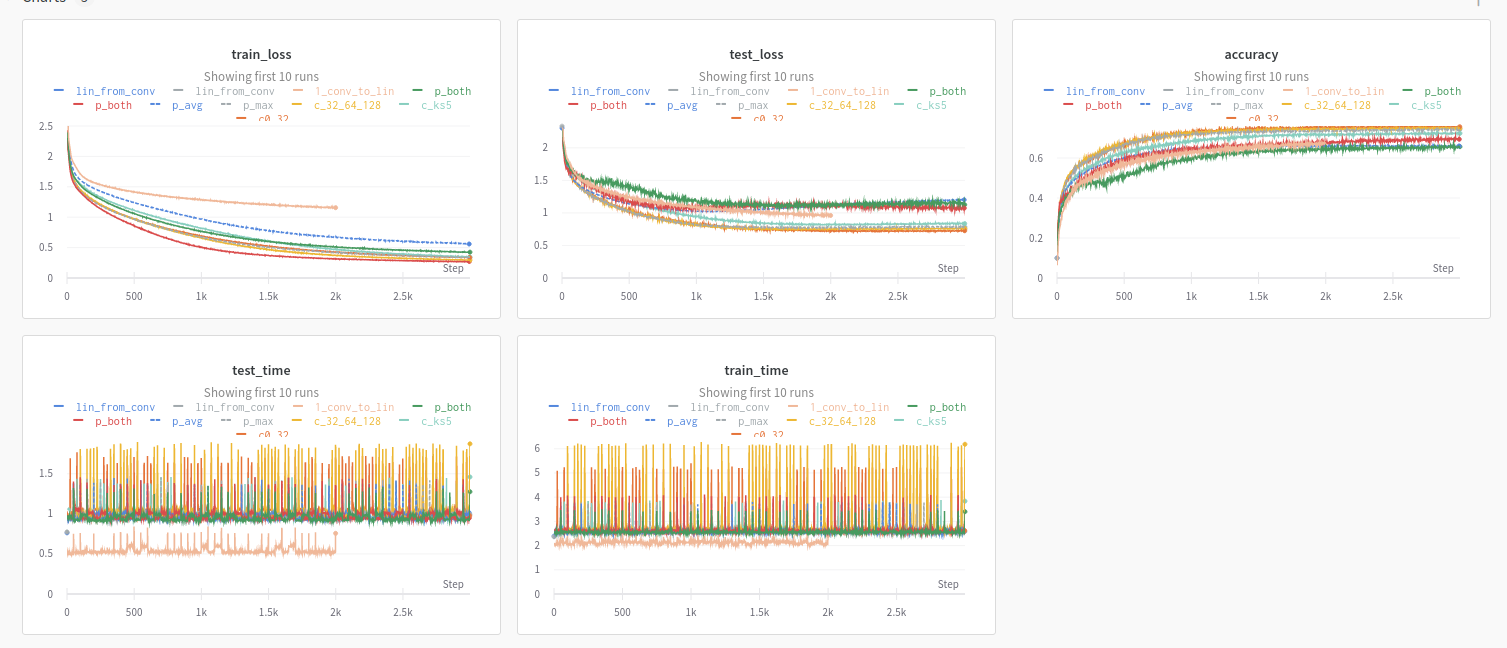

## activations
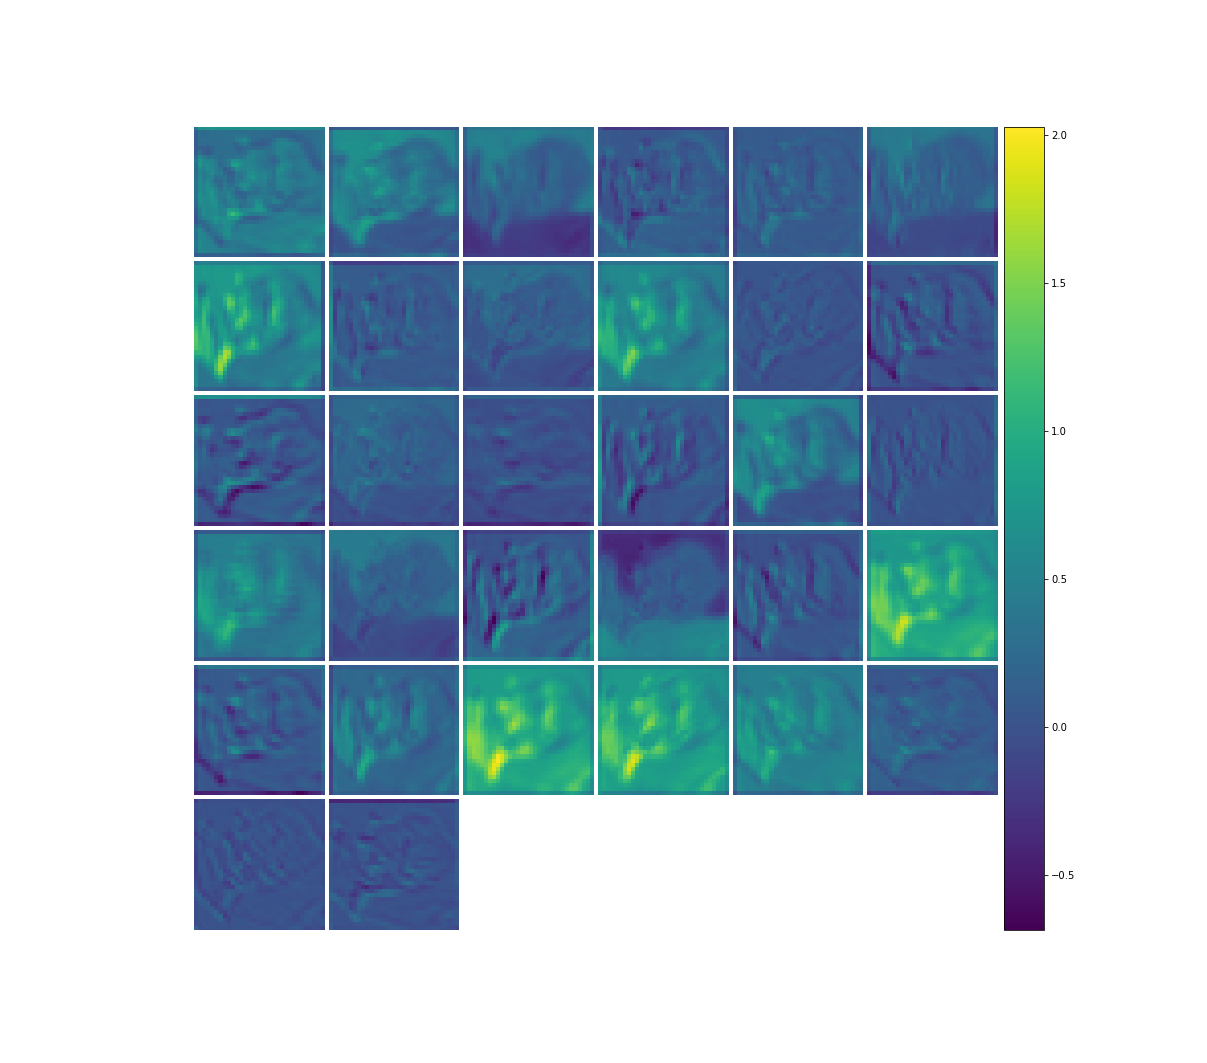

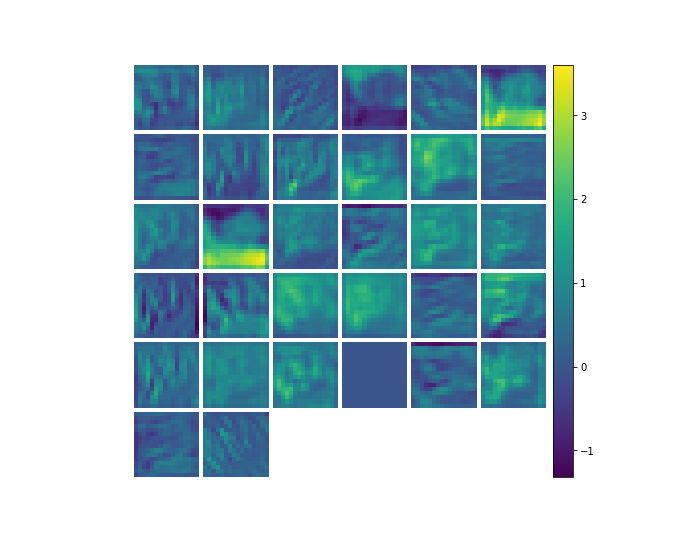

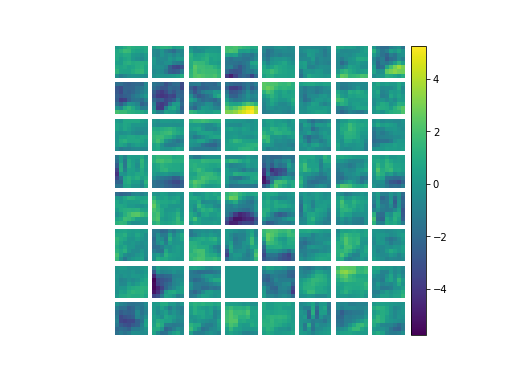

## weights
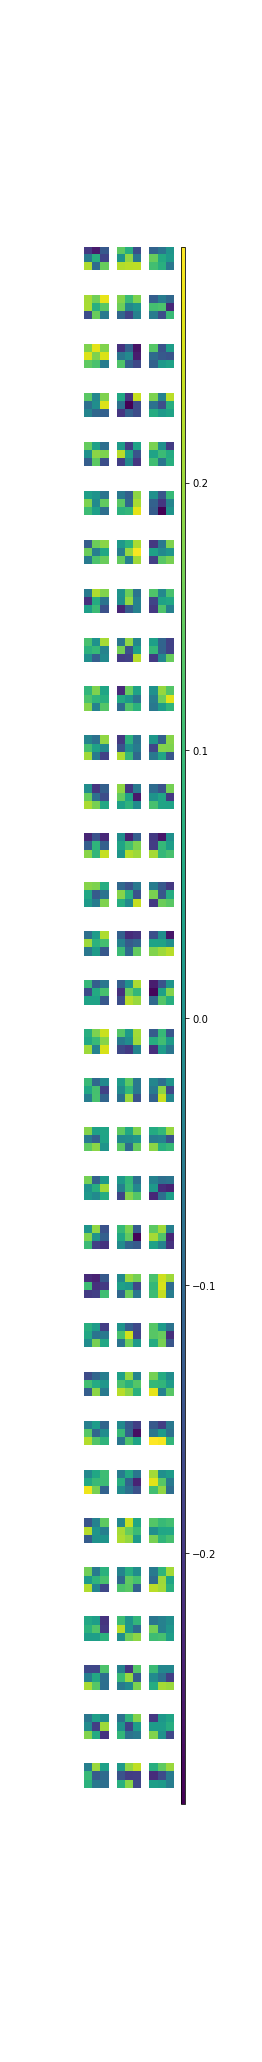

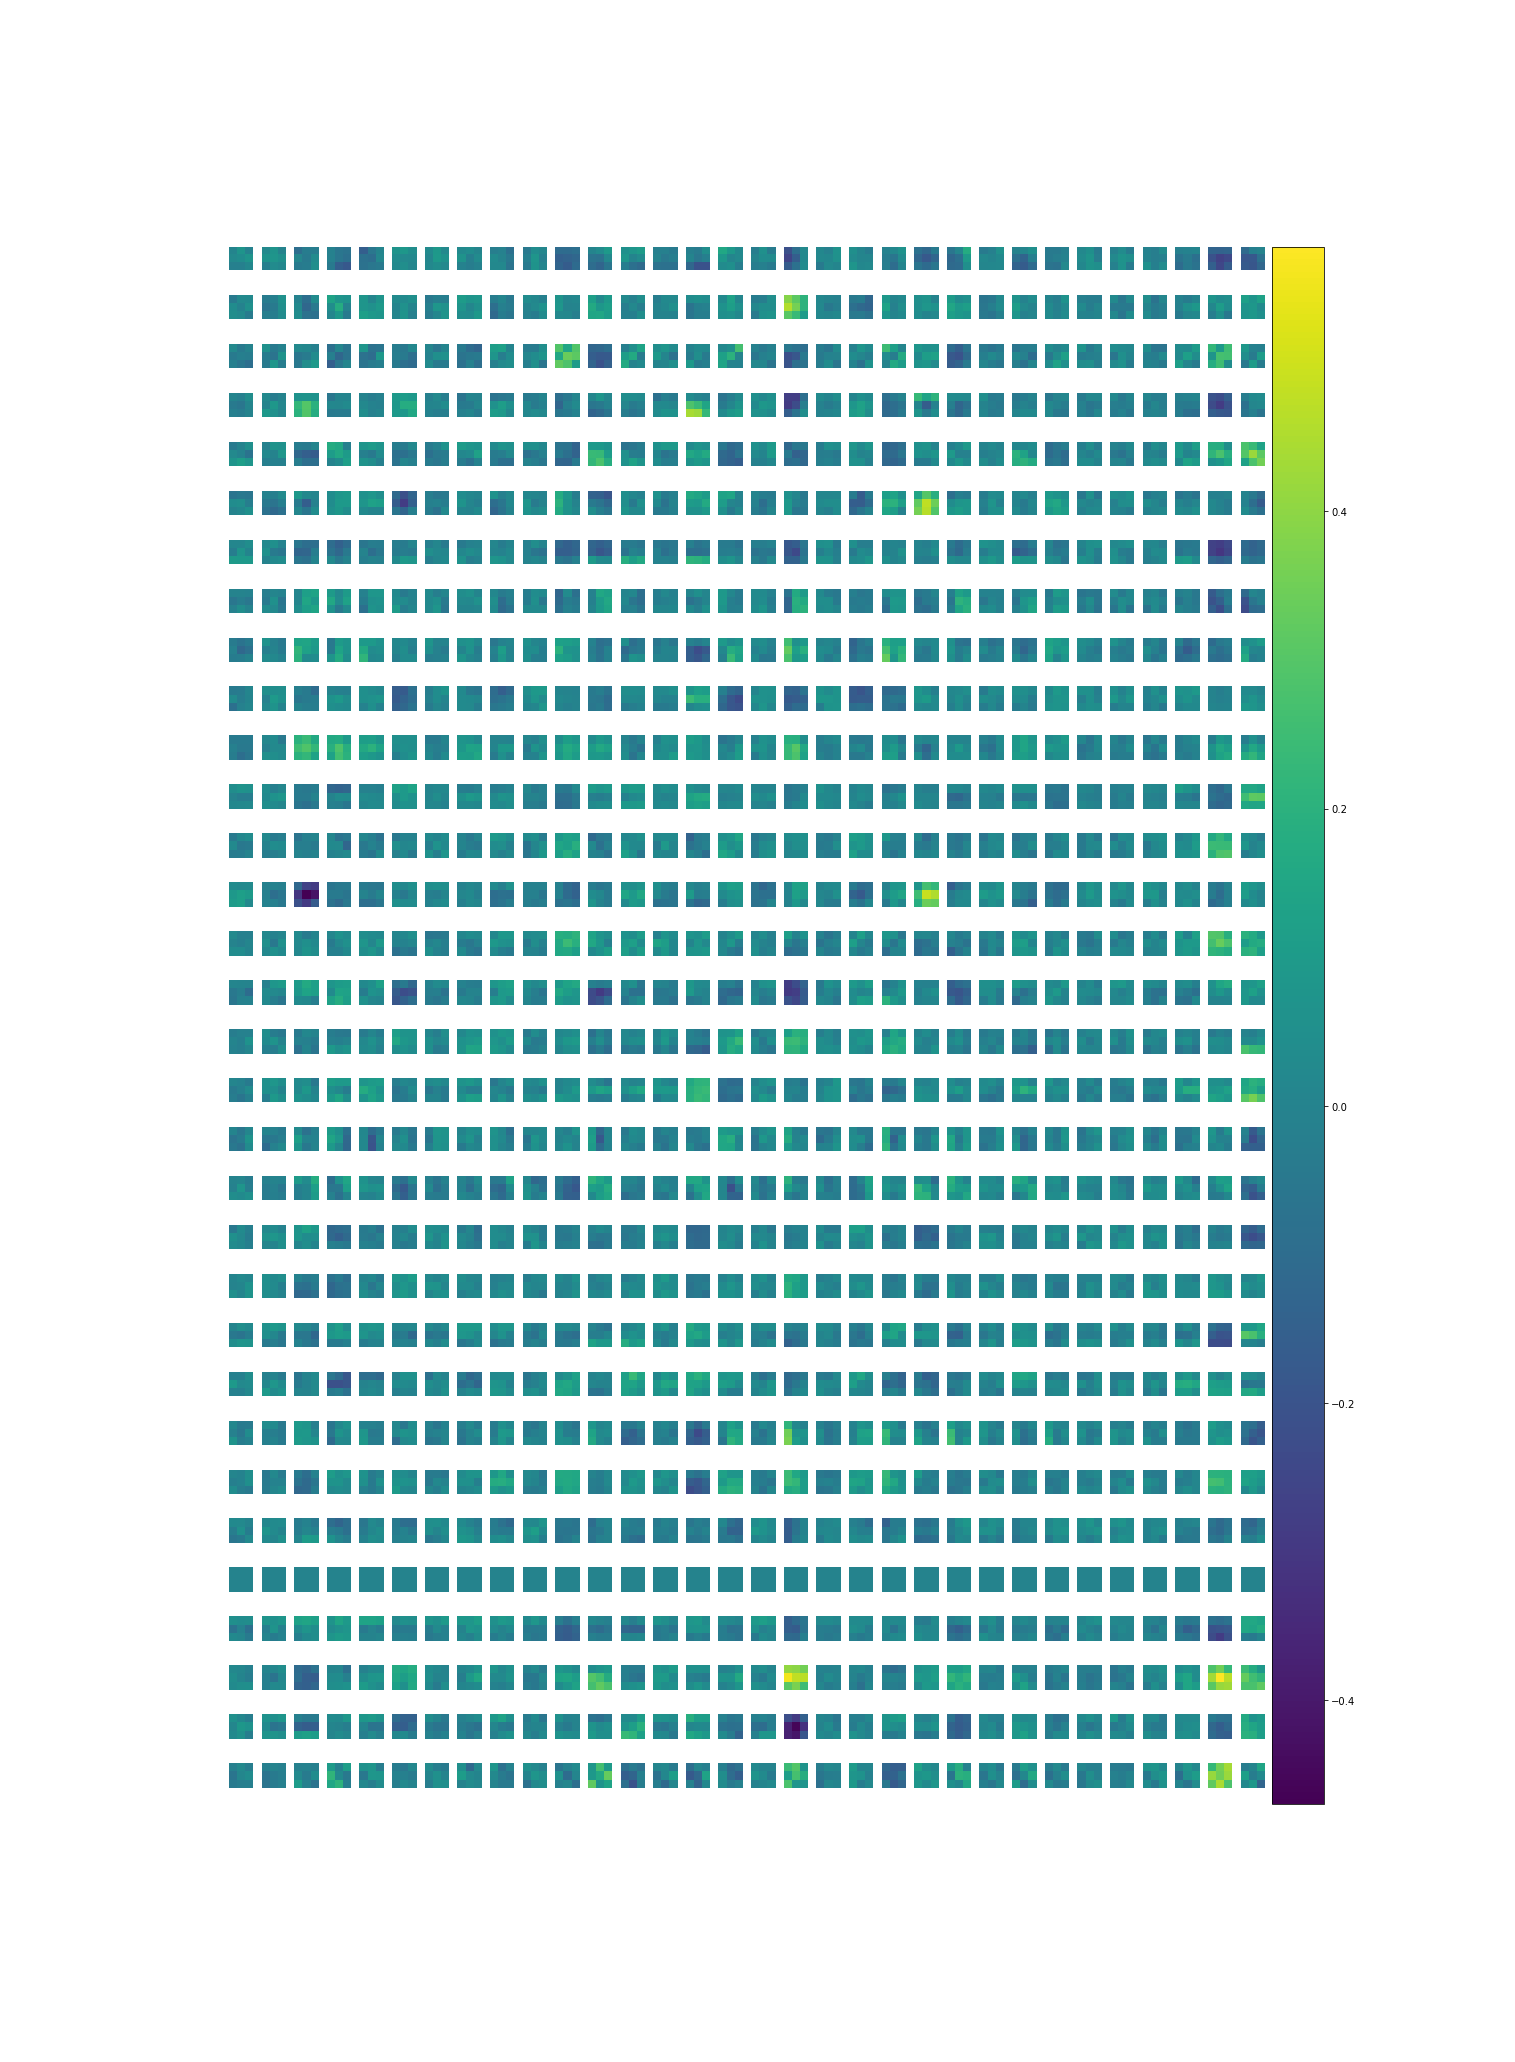

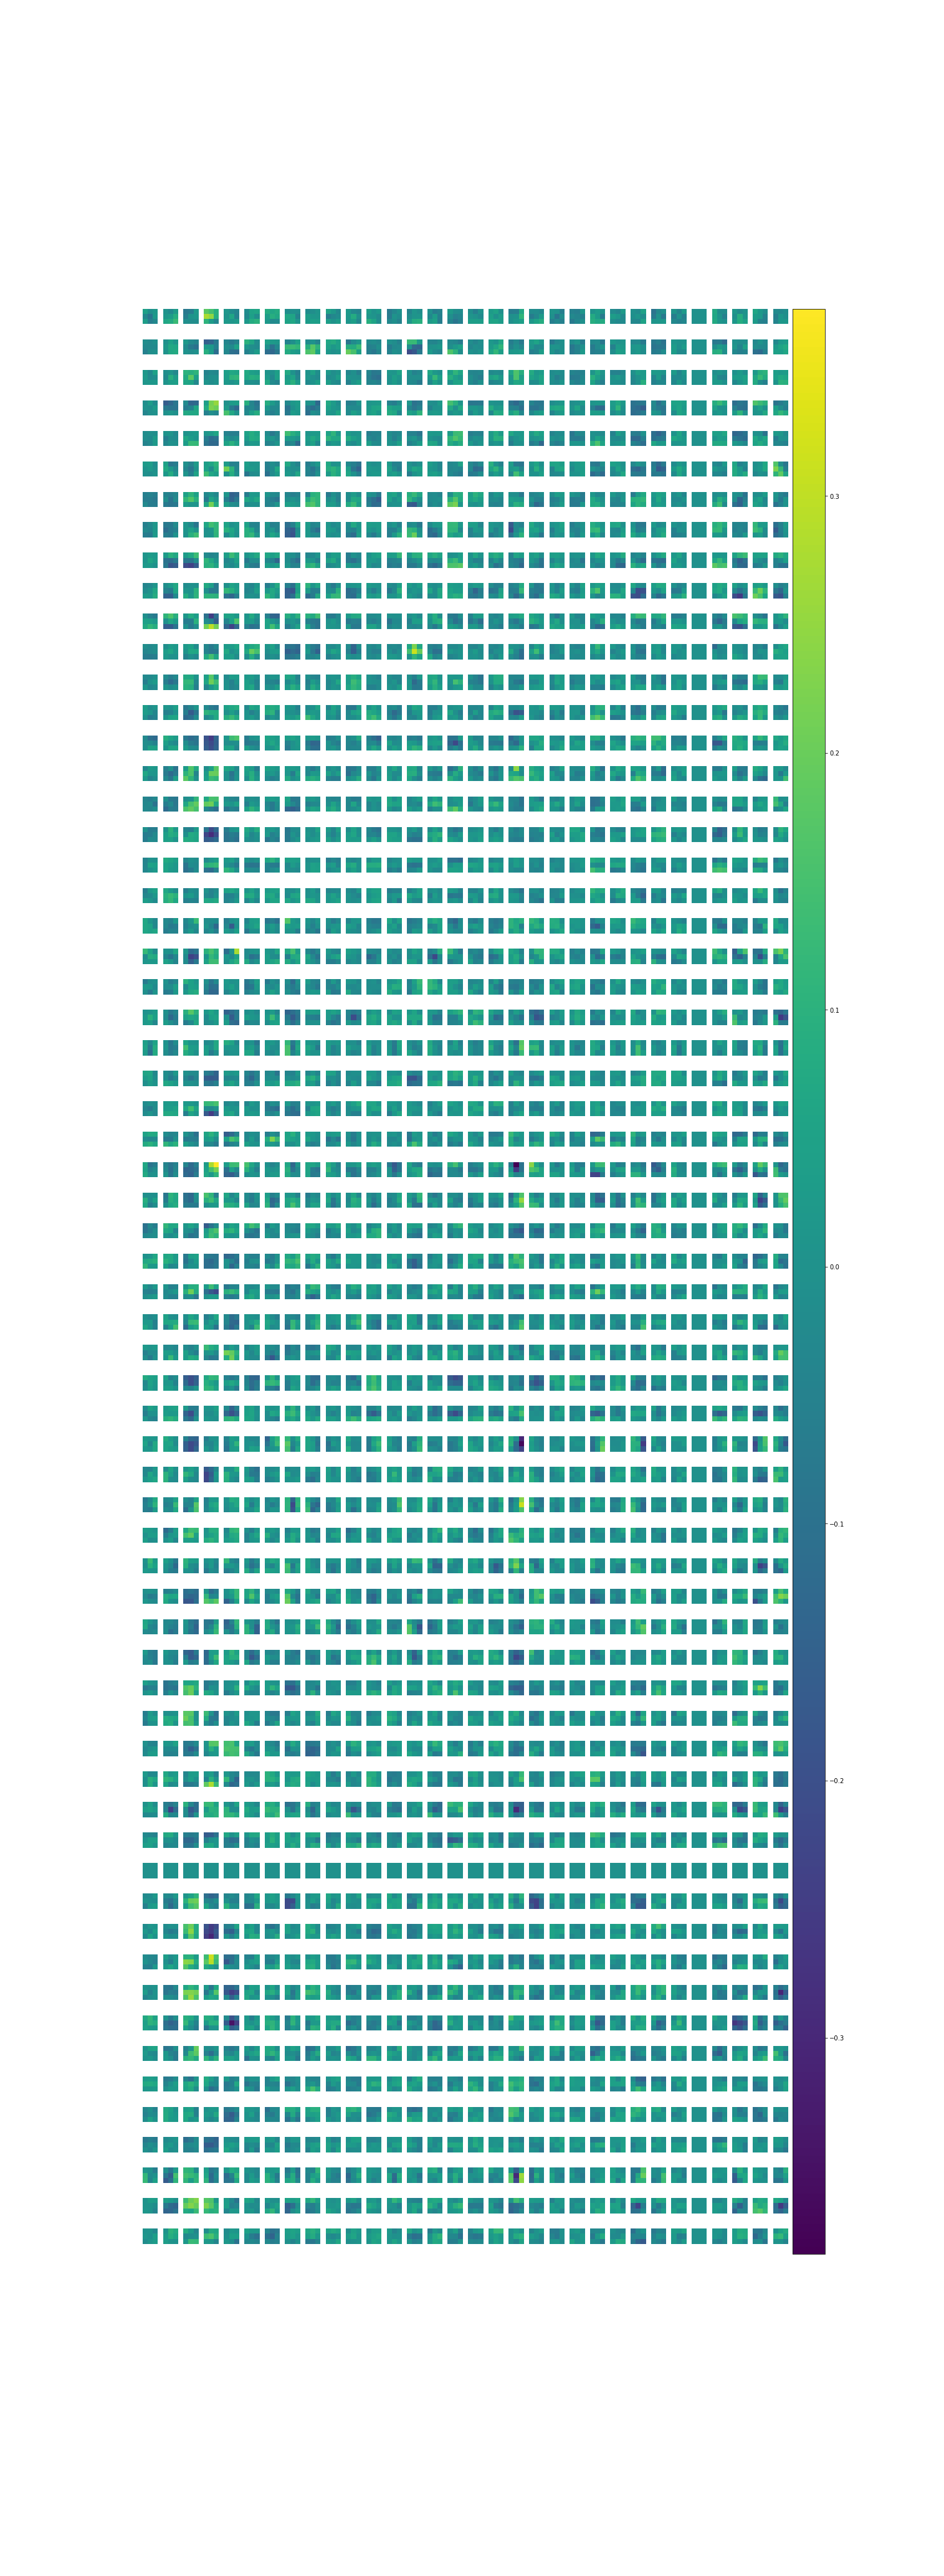